# Задачи к Лекции 2

__Исходные данные__ 

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Для начала посмотрим на наши данные.

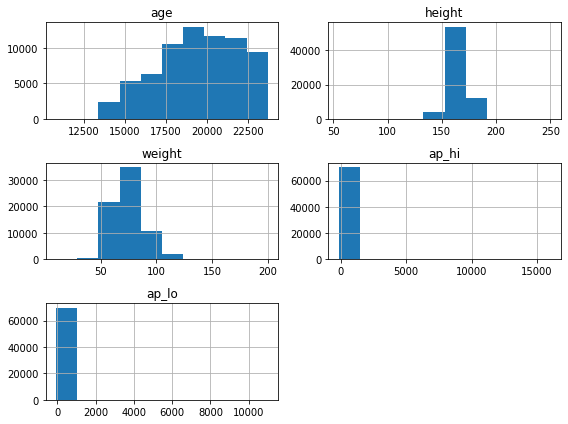

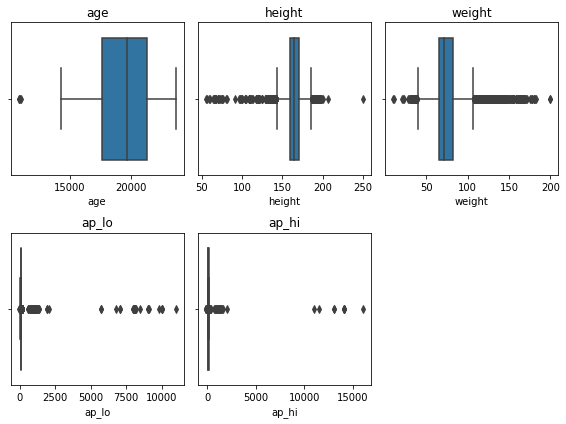

In [8]:
df[["age", "height", "weight", "ap_hi", "ap_lo"]].hist()
plt.tight_layout()
plt.show()

for i, col in enumerate(["age", "height", "weight", "ap_lo", "ap_hi"]):
    plt.subplot(231 + i)
    plt.title(col)
    sns.boxplot(df[col])
plt.tight_layout() # это нужно, чтобы графики друг на друга не налезали
plt.show()

Можно увидеть, что для роста, давлений и веса есть выбросы явно указывающие на ошибки в данных, либо на их незначительность и редкость.

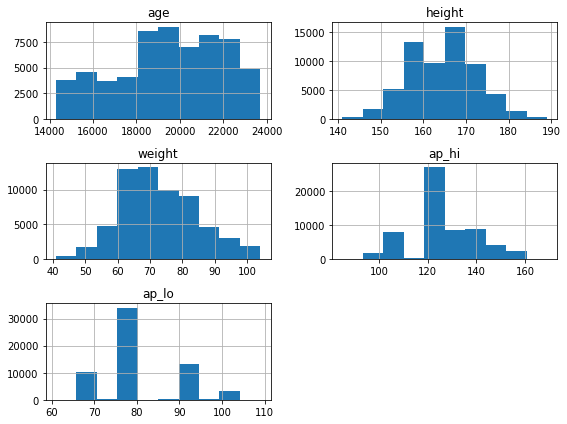

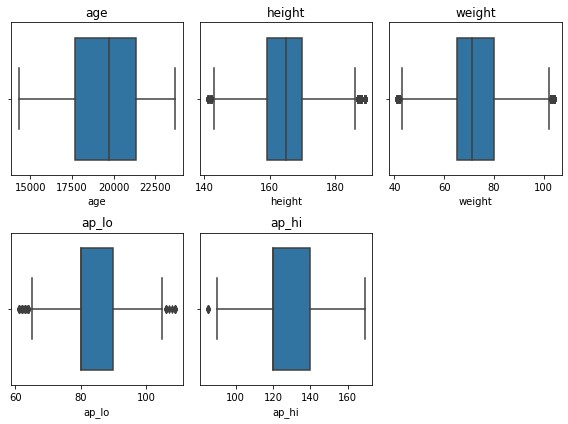

In [10]:
data = df[(df["age"] > 12500)&
          (df["weight"] > 40)&(df["weight"] < 105)&
          (df["height"] > 140)&(df["height"] < 190)&
          (df["ap_lo"] > 60)&(df["ap_lo"] < 110)&
          (df["ap_hi"] > 80)&(df["ap_hi"] < 170)
         ]

data[["age", "height", "weight", "ap_hi", "ap_lo"]].hist()
plt.tight_layout()
plt.show()

for i, col in enumerate(["age", "height", "weight", "ap_lo", "ap_hi"]):
    plt.subplot(231 + i)
    plt.title(col)
    sns.boxplot(data[col])
plt.tight_layout() # это нужно, чтобы графики друг на друга не налезали
plt.show()

Таким образом мы убрали некорректные значения и убрали редкие значения.

In [38]:
# чтобы красиво строилась матрица
from sklearn.metrics import confusion_matrix
import itertools

class_names = ["Здоров", "Болен"]
def plot_confusion_matrix(cm, classes, normalize=False, title='Матрица неточностей', cmap=plt.cm.Blues):    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=0)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.min() + (cm.max() - cm.min()) * 2 / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Истина')
    plt.xlabel('Предсказание')
    plt.tight_layout()

## Задачи

**1. Построить наивный байесовский классификатор для количественных полей age, height, weight, ap_hi, ap_lo. Исправить данные, если это необходимо. Привести матрицу неточностей и сравнить со значением полученным в ходе лекции. Попытаться объяснить разницу.**

Точность = 0.705188


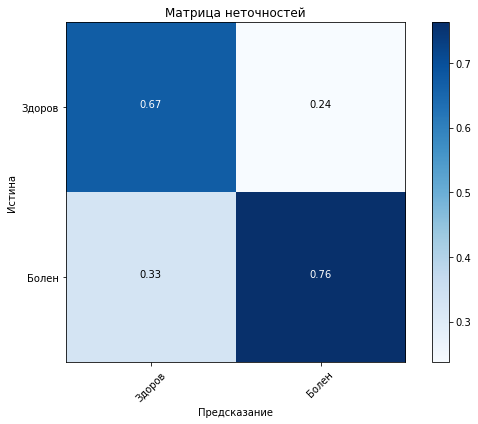

In [40]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

train = data[["age", "height", "weight", "ap_hi", "ap_lo"]]
target = data["cardio"]

gnb = GaussianNB()
model = gnb.fit(train, target)
gprob = gnb.predict_proba(train)
gpred = gnb.predict(train)

acc = accuracy_score(target, gpred) # напоминаю, это просто процент правильно угаданных прецендентов
cnf = confusion_matrix(target, gpred)

print("Точность = %f" % acc)
plot_confusion_matrix(cnf, class_names, normalize=True)

**Комментарии:** Здесь можно увидеть, что не смотря на относительно высокий процент правильных ответов, мы видим, что в случае диагноза "болен" наш классификатор ошибается существенно реже, в случае "здоров".

**2. Придумать как построить наивный байесовский классификатор для категориальных полей cholesterol, gluc. Привести матрицу неточностей и сравнить со значениями из задачи 1. (MultinomialNB здесь не подходит, как и ComplementNB)**

In [41]:
from collections import defaultdict

class CategorialNB:
    """
        Относительно универсальный бинарный классификатор по категориальным данным.
        Требует, чтобы категории были заменены на числа. Довольно легко обобщается
        до многоклассового классификатора. Целевой исход должен быть 0 или 1
    """
    def __init__(self, weight = None):
        # Здесь мы будем хранить вероятности по признакам и классам
        # Это будет список списка словарей.
        # n-ому признаку. В словаре будут хранится вероятности для дискретных
        # значений категориальных данных
        self.model_0 = [] 
        self.model_1 = []
        
        # веса классов (наша априорная вероятность)
        if weight is None:
            self.weight = [0.5, 0.5] 
        else:
            # Нормируем веса на 1
            w = weight[0] + weight[1]
            self.weight = [weight[0] / w, weight[1] / w]
        
    def fit(self, data, target):
        # приводим все к типам numpy
        # здесь по идее нужна проверка на то, что данные были правильно представлены,
        # т.е. количество признаков в каждом преценденте одно и то же
        data = np.array(data)
        target = np.array(target)
        
        # количество прецедентов
        N = data.shape[0]
        
        # Количество признаков категориальных
        feature_count = data.shape[1]

        # проверяем одинаковую размерность
        if data.shape[0] != target.shape[0]:
            raise Exception("Invalid shapes of data vector and target vector")
            
        # проверяем, что целевой исход должен быть либо 0, либо 1
        if np.logical_not(np.isin(target, [0, 1])).any():
            raise Exception("Invalid target vector")

        # Подготавливаем нашу модель
        self.model_1 = [{} for _ in range(feature_count)]
        self.model_0 = [{} for _ in range(feature_count)]
            
        # отбираем данные класса 1 и класса 2
        mask_1 = target == 1
        mask_0 = target == 0                    
            
        # Теперь просто подсчитываем частоты в каждой категории
        # По сути, мы по порядку проходимся по каждому категориальному признаку
        for i in range(feature_count):
            # получаем отдельные категории и сколько раз они встречаются
            # для класса 1
            cats, counts = np.unique(data[mask_1, i], return_counts=True)
            probs = counts / N # Теперь это вероятность   
            # проходимся по всем категориям и сопоставленым им вероятностям
            # записываем это в словарь
            for category, probability in zip(cats, probs):
                self.model_1[i][category] = probability # сохраняем
                
            # тоже самое для класса 0
            cats, counts = np.unique(data[mask_0, i], return_counts=True)
            probs = counts / N # Теперь это вероятность            
            for category, probability in zip(cats, probs):
                self.model_0[i][category] = probability
        #print(self.model)
        return self
    
    def predict_proba(self, data):
        """
            Сделать предсказание на основе полученных распределений
        """
        # Переводим в numpy-массив
        data = np.array(data)
        result = np.zeros((data.shape[0], 2))
        result[:, 0] = self.weight[0]
        result[:, 1] = self.weight[1]
        
        for i, row in enumerate(data):
            for j, feature in enumerate(row):
                result[i, 0] = result[i, 0] * self.model_0[j][feature]
                result[i, 1] = result[i, 1] * self.model_1[j][feature]        
        return result / result.sum(axis=1)[:, None]
    
    def predict(self, data):
        """
            Просто предсказываю вероятности и выбираю класс с наибольшей
        """
        proba = self.predict_proba(data)                
        mask = proba[:, 1] > proba[:, 0]
        return mask.astype("int")

Точность = 0.591474


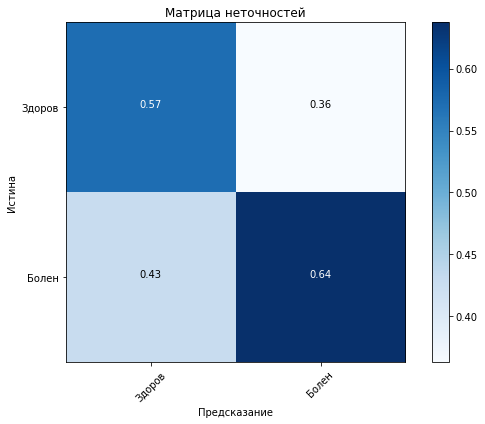

In [42]:
train = data[["cholesterol", "gluc"]]
target = data["cardio"]
cnb = CategorialNB()

cnb.fit(train, target)
cprob = cnb.predict_proba(train)
cpred = cnb.predict(train)

acc = accuracy_score(target, cpred) # напоминаю, это просто процент правильно угаданных прецендентов
cnf = confusion_matrix(target, cpred)

print("Точность = %f" % acc)
plot_confusion_matrix(cnf, class_names, normalize=True)

Точность = 0.591474


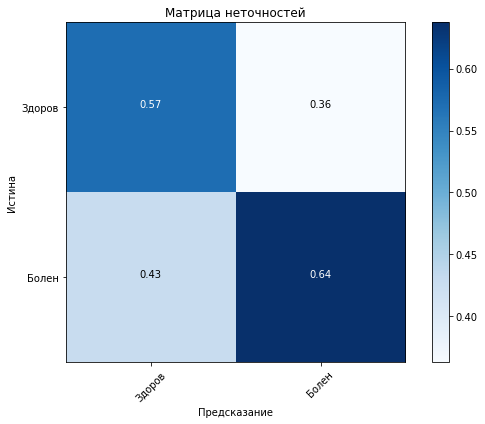

In [43]:
# Проверим на реализации sklearn
from sklearn.naive_bayes import CategoricalNB

cnb = CategoricalNB()

cnb.fit(train, target)
cprob = cnb.predict_proba(train)
cpred = cnb.predict(train)

acc = accuracy_score(target, cpred) # напоминаю, это просто процент правильно угаданных прецендентов
cnf = confusion_matrix(target, cpred)

print("Точность = %f" % acc)
plot_confusion_matrix(cnf, class_names, normalize=True)

**Комментарии:** Можно увидеть, что точность сопоставима с признаками, что представлены в лекции. Хотя имеется значительный перекос в сторону ложно-здоровых людей.

Альтернативным вариантом является использование, т.н. One-Hot кодирования. Когда мы создаем множество новых бинарных признаков, которые фактически отвечают на вопрос "Это значение X?". А вот к бинарным признакам мы можем применить BernoulliNB.

In [44]:
# мы может так сделать, т.к. False и True - это фактически 0 и 1
data["gluc_1"] = data["gluc"] == 1 
data["gluc_2"] = data["gluc"] == 2
data["gluc_3"] = data["gluc"] == 3

data["chol_1"] = data["cholesterol"] == 1
data["chol_2"] = data["cholesterol"] == 2
data["chol_3"] = data["cholesterol"] == 3

Точность = 0.591474


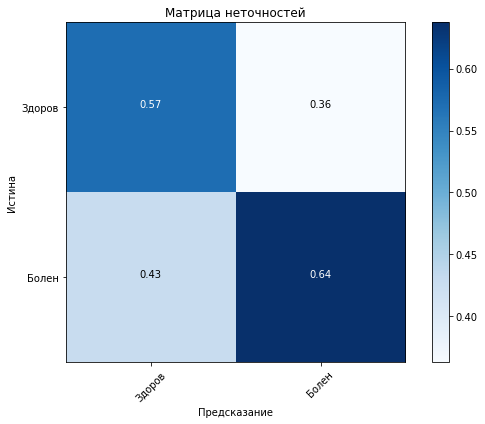

In [45]:
from sklearn.naive_bayes import BernoulliNB

train = data[["gluc_1", "gluc_2", "gluc_3", "chol_1", "chol_2", "chol_3"]]
target = data['cardio']

cbnb = BernoulliNB()
cbnb.fit(train, target)
cbprob = cbnb.predict_proba(train)
cbpred = cbnb.predict(train)

acc = accuracy_score(target, cbpred) # напоминаю, это просто процент правильно угаданных прецендентов
cnf = confusion_matrix(target, cbpred)

print("Точность = %f" % acc)
plot_confusion_matrix(cnf, class_names, normalize=True)

**Комментарии:** Как видно, в данном случае разница не заметна с предыдущим результатом.

**3. Построить наивный байесовский классификатор для бинарных полей gender, smoke, alco, active. Привести матрицу неточностей и сравнить с предыдущими значениями.**

Точность = 0.520472


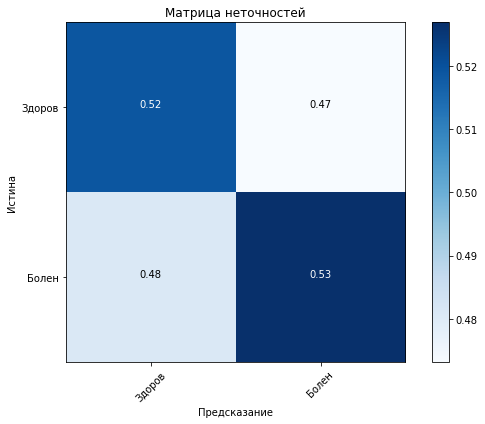

In [46]:
from sklearn.naive_bayes import BernoulliNB

# В начале приводим пол к бинарному признаку
data['gender_b'] = data['gender'].map({1: 0, 2: 1})

train = data[["gender_b", "smoke", "alco", "active"]]
target = data['cardio']

bnb = BernoulliNB()
bnb.fit(train, target)
bprob = bnb.predict_proba(train)
bpred = bnb.predict(train)

acc = accuracy_score(target, bpred) # напоминаю, это просто процент правильно угаданных прецендентов
cnf = confusion_matrix(target, bpred)

print("Точность = %f" % acc)
plot_confusion_matrix(cnf, class_names, normalize=True)

**Комментарии:** В данном случае видно, что точность предсказания на уровне броска монеты. 

**4. К этому моменту у вас есть три независимых классификатора: по количественным полям, категориальным и бинарным. Придумать, как их объединить в один единый классификатор, который учитывает все эти поля. Привести матрицу неточностей для него и сравнить с предыдущими значениями. Попытаться объяснить разницу.**

Самым очевидным подходом является использование теоремы Байса. Мы уже знаем, что

$$
P(болен | \vec{x}) \propto P(болен) P(x_1|болен) \ldots P(x_K|болен)
$$

При этом, у нас есть заранее подготовленные три группы классификаторов для трех групп признаков: $[x_1, \ldots, x_{k_1}]$, $[x_{k_1}, \ldots, x_{k_2}]$ и $[x_{k_2}, \ldots, x_K]$

$$
P(болен | x_1, \ldots, x_{k_1} ) \propto P(болен) P(x_1|болен) \ldots P(x_{k_1}|болен)
\\
P(болен | x_{k_1}, \ldots, x_{k_2} ) \propto P(болен) P(x_{k_1}|болен) \ldots P(x_{k_2}|болен)
\\
P(болен | x_{k_2}, \ldots, x_K ) \propto P(болен) P(x_{k_2}|болен) \ldots P(x_K|болен)
$$

Откуда мы можем найти итоговую вероятность, если сопоставим все выражения

$$
P(болен | \vec{x}) \propto \frac{ P(болен | x_1, \ldots, x_{k_1} ) P(болен | x_{k_1}, \ldots, x_{k_2} ) P(болен | x_{k_2}, \ldots, x_K )}{P(болен) P(болен)}
$$

и тоже самое для "здоров". Априорные вероятности будем считать равными 50%.

Точность = 0.715196


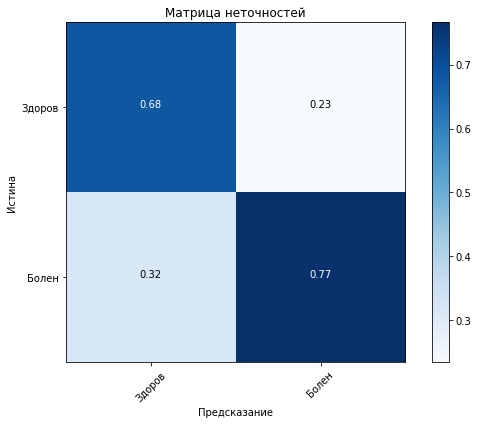

In [48]:
target = data['cardio']

# здесь я сразу выкинул одинаковый везде множитель в 1/4. Перемножил полученные вероятности и разделил
# на их сумму, чтобы отнормировать
prob = (gprob * cprob * bprob) / (gprob * cprob * bprob).sum(axis=1)[:,None]
predict = (prob[:,1] > prob[:,0]).astype("int")

acc = accuracy_score(target, predict) # напоминаю, это просто процент правильно угаданных прецендентов
cnf = confusion_matrix(target, predict)

print("Точность = %f" % acc)
plot_confusion_matrix(cnf, class_names, normalize=True)

**Комментарии:** Использование всех распределений позволило улучшить результат с 0.705188 до 0.714694.

**5. (Не обязательно) Теперь мы умеем делать классификацию в рамках наивного предположения об независимости всех признаков. Сейчас же нужно попробовать учесть взаимосвязь между признаками через условные вероятности. Построить классификатор с учетом такой связи. Сравнить результат с ранее полученными значениями.**

Рассмотрим самый простой вариант. Пусть "age", "height", "weight", "ap_lo", "ap_hi" зависят от показателей "cholesterol" и "gluc". Построив простенькую байесову сеть, мы можем легко записать факторизацию полной вероятности

$$
P(\vec{x}|болен) = P(age, height, weight, ap\_lo, ap\_hi | cholesterol, gluc, болен) P(cholesterol | болен) P(gluc | болен)
$$

Это эквивалентно тому, что мы строим GaussianNB для каждой пары значений 

$$
P(\vec{x}|болен) = P_{NB}(болен |age, height, weight, ap\_lo, ap\_hi, cholesterol, gluc ) \frac{P(cholesterol | болен) P(gluc | болен)}{P(болен)}
$$

In [51]:
# Возможные пары значений
pairs = [
    (1, 1), (1, 2), (1, 3),
    (2, 1), (2, 2), (2, 3),
    (3, 1), (3, 2), (3, 3),
]

# Здесь будем хранить наши наивные байесы
model = {}


train = data[["cholesterol", "gluc", "age", "height", "weight", "ap_lo", "ap_hi"]]
target = data["cardio"]

# Условные вероятности для наших категориальных данных
P_cholesterol_1 = train[target == 1]["cholesterol"].value_counts() / (target == 1).sum()
P_cholesterol_0 = train[target == 0]["cholesterol"].value_counts() / (target == 0).sum()

P_gluc_1 = train[target == 1]["gluc"].value_counts() / (target == 1).sum()
P_gluc_0 = train[target == 0]["gluc"].value_counts() / (target == 0).sum()

# строим девять GaussianNB
for p in pairs:
    mask = (train["cholesterol"] == p[0]) & (train["gluc"] == p[1]) 
    nb = GaussianNB()
    
    tmp = train[["age", "height", "weight", "ap_lo", "ap_hi"]]

    nb.fit(tmp[mask], target[mask])
    model[p] = nb
    
    

predict_proba = np.zeros( (target.shape[0], 2) )
predict_proba[:, 0] = 1 # Просто, чтобы было, можно не делать

# Делаем предсказания
for p in pairs:
    mask = (train["cholesterol"] == p[0]) & (train["gluc"] == p[1])
    nb = model[p]
    
    tmp = train[["age", "height", "weight", "ap_lo", "ap_hi"]]
    
    prob = nb.predict_proba(tmp[mask])
    prob[:, 0] = prob[:, 0] * P_cholesterol_0[p[0]] * P_gluc_0[p[1]]
    prob[:, 1] = prob[:, 1] * P_cholesterol_1[p[0]] * P_gluc_1[p[1]]
    
    # Нормируем на единицу. [:, None] - это для того, чтобы форма тензора была правильной
    prob = prob / prob.sum(axis=1)[:, None]
    predict_proba[mask] = prob

# Выбираем класс исходя из максимальной вероятности
predict = (predict_proba[:, 1] >= predict_proba[:, 0]).astype("int")
acc = accuracy_score(target, predict)
print(acc)

0.7181001200402297


**Комментарии:** Получили улучшение с 0.714 до 0.718. Дальшейшего улучшения можно получить, допустим, учтя то, что вес и рост связаны друг с другом.